In [2]:
import torch

In [3]:
#!pip install segmentation-models-pytorch

In [4]:
#!pip install -U  albumentations --user 

In [5]:
#!pip install datasets

In [6]:
 %load_ext autoreload

 %autoreload 2


In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [8]:
from torchvision.datasets import Cityscapes

In [9]:
from datasets import load_dataset

In [10]:
train_dataset = load_dataset("Chris1/cityscapes", split="train")
val_dataset = load_dataset("Chris1/cityscapes", split="validation")

Using custom data configuration Chris1--cityscapes-2bd50e1e8cc703b7
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Found cached dataset parquet (/home/ec2-user/.cache/huggingface/datasets/Chris1___parquet/Chris1--cityscapes-2bd50e1e8cc703b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Using custom data configuration Chris1--cityscapes-2bd50e1e8cc703b7
Found cached dataset parquet (/home/ec2-user/.cache/huggingface/datasets/Chris1___parquet/Chris1--cityscapes-2bd50e1e8cc703b7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


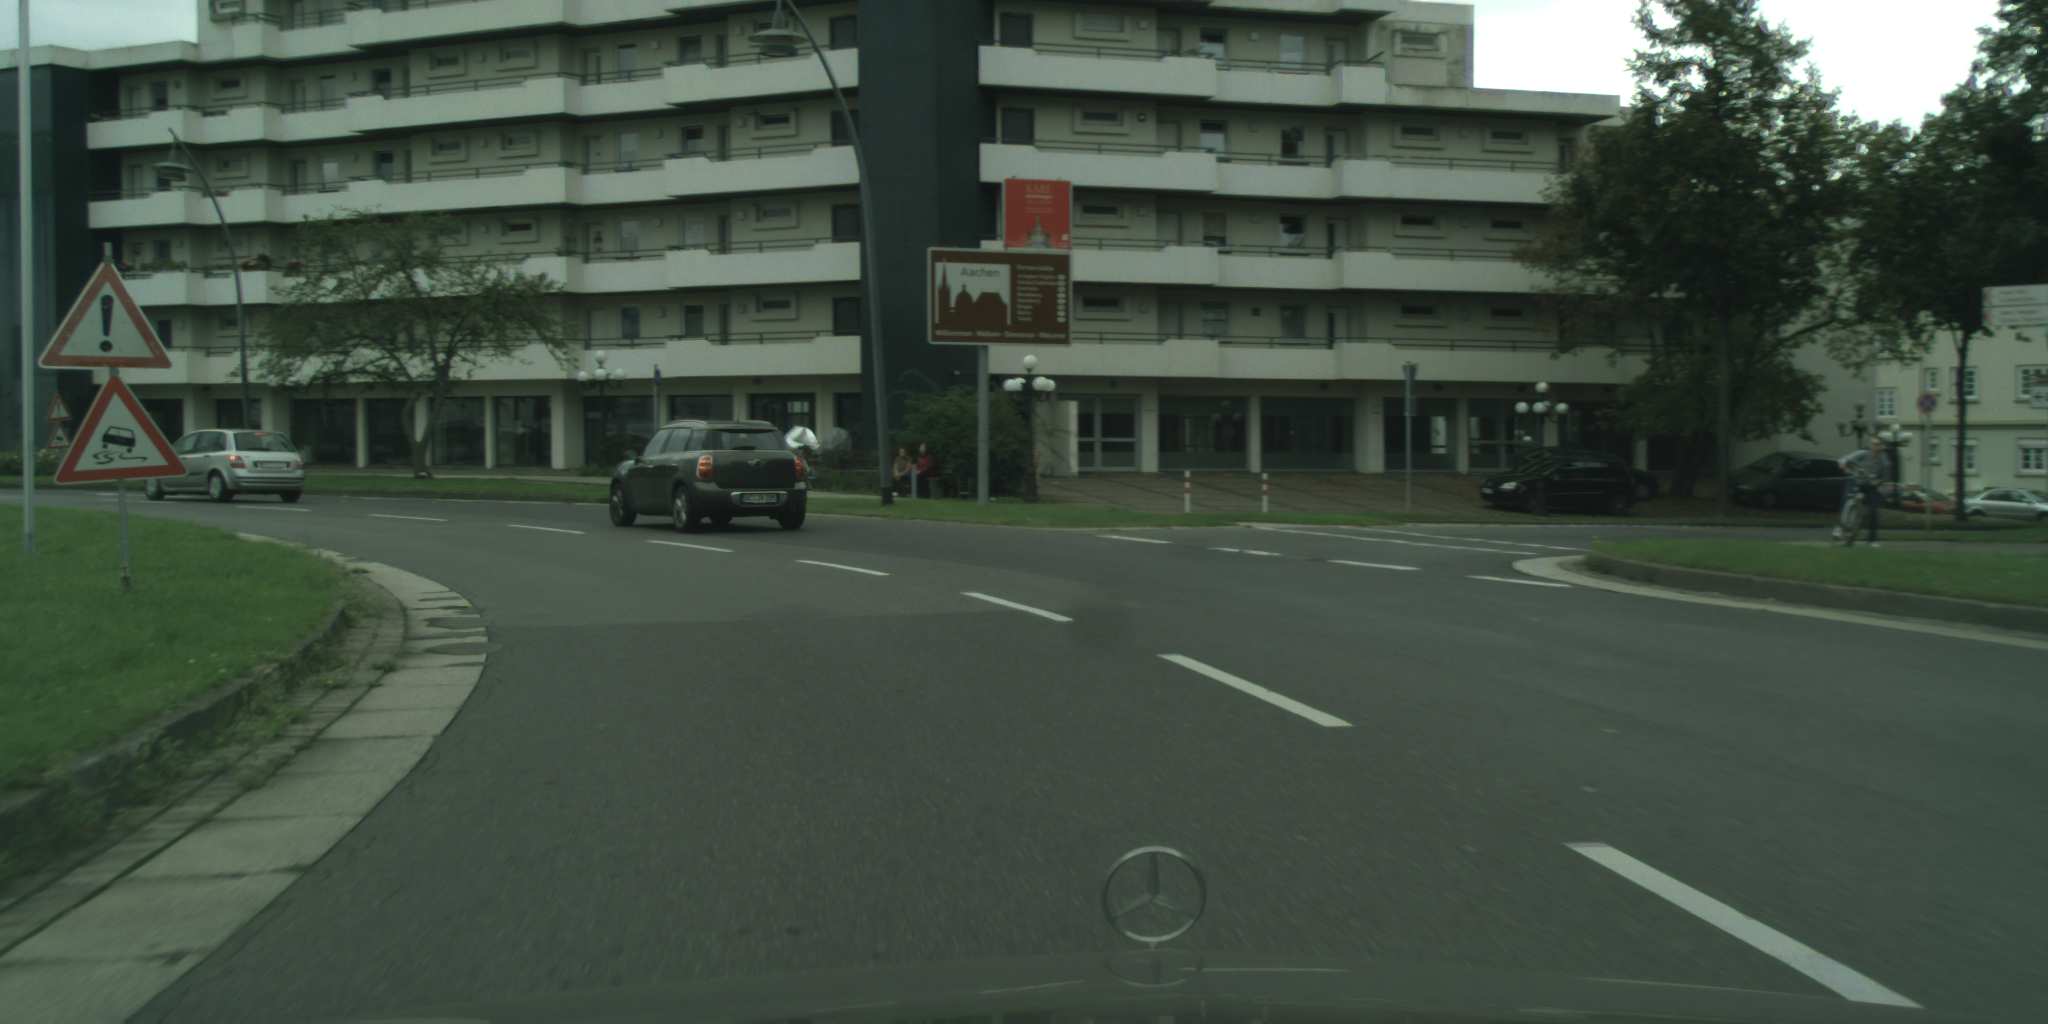

In [11]:
train_dataset[0]["image"]

In [12]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024 at 0x7F0BB86B3AF0>,
 'semantic_segmentation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2048x1024 at 0x7F0BB86B3760>}

In [13]:
import torchvision.transforms as transform
import torch
from torchvision.transforms import InterpolationMode 
import numpy as np

mean=torch.tensor([0.4850, 0.4560, 0.4060])
std=torch.tensor([0.2290, 0.2240, 0.2250])


transformsImage = transform.Compose(
    [
        transform.Resize((512,512),interpolation=InterpolationMode.BILINEAR),
        transform.ToTensor(),
        transform.Normalize(mean, std)
    ]
)

transformsLabel = transform.Compose(
    [
        transform.Resize((512,512),interpolation=InterpolationMode.NEAREST),
        transform.Lambda(lambda t: torch.as_tensor(np.array(t), dtype=torch.int64))
    ]
)

postprocess = transform.Compose([
     transform.Lambda(lambda t: (t.cpu() * std.reshape(3,1,1))+mean.reshape(3,1,1)),
     transform.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transform.Lambda(lambda t: t * 255.),
     transform.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
])



In [14]:
import torch.utils.data as baseData
import torch
from torch.utils.data import DataLoader

class CityscapeData(baseData.Dataset):
    def __init__(self,ds,img_sz=512):
        super(CityscapeData, self).__init__()
        self.img_sz=img_sz
        self.ds=ds
        self.class_values=[i for i in range(35)]
        
    def __getitem__(self, index):
        
        img = self.ds[index]["image"]
        masks = self.ds[index]["semantic_segmentation"]
        img=transformsImage(img)
        masks=transformsLabel(masks)[...,0]
        #masks = [(masks == v) for v in self.class_values]
        #masks = torch.stack(masks,axis=0).float()
        return img,masks
    
    def __len__(self):
        return len(self.ds)

In [15]:
train_Data=CityscapeData(train_dataset)
val_Data=CityscapeData(val_dataset)

In [16]:
for img,msk in train_Data:
    print(img.shape)
    print(msk.shape)
    print(msk.unique())
    break

torch.Size([3, 512, 512])
torch.Size([512, 512])
tensor([ 0,  1,  3,  4,  7,  8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33])


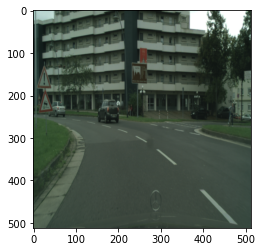

In [17]:
import matplotlib.pyplot as plt
plt.imshow(postprocess(img))

In [18]:
BATCH_SIZE=8
train_loader = DataLoader(dataset=train_Data, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(dataset=val_Data, batch_size=BATCH_SIZE)

torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])


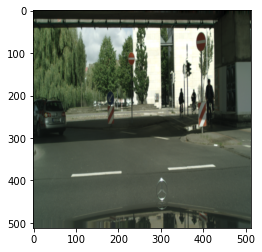

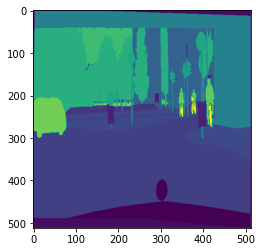

In [19]:
for batch in train_loader:
    img,msk=batch
    print(img.shape)
    print(msk.shape)
    img=postprocess(img[0])
    plt.imshow(img)

    plt.figure(2)
    plt.imshow(msk[0].detach().numpy())
    break

In [20]:
import segmentation_models_pytorch as smp
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=35, 
    activation=ACTIVATION,
)

In [33]:
class F1(torch.nn.Module):
    __name__ = "f1"

    def __init__(self, threshold=None,mode="multiclass",num_classes=35,**kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.mode = mode
        self.class_values=[i for i in range(35)]
        self.classes=num_classes

    def forward(self, output, target):
        #masks = [(target == v) for v in self.class_values]
        #masks = torch.stack(masks,axis=1).int()
        output=output.argmax(axis=1)
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, num_classes=self.classes,mode=self.mode, threshold=self.threshold)
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
        return f1_score

In [34]:
from segmentation_models_pytorch.utils import train

loss = smp.losses.DiceLoss(mode="multiclass")
metrics = [F1(num_classes=35)]
optimizer = torch.optim.Adam([ dict(params=model.parameters(), lr=0.0001)])

In [35]:
from segmentation_models_pytorch.utils import train

In [36]:
max_score = 0

for i in range(0, 200):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['f1']:
        max_score = valid_logs['f1']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:  17%|█▋        | 64/372 [03:41<17:49,  3.47s/it, DiceLoss - 0.7432, f1 - 0.1855] 

In [ ]:
## Test Trained MODEL

In [25]:
model=torch.load("../best_model.pth")

In [41]:
val_loader = DataLoader(dataset=val_Data, batch_size=8,shuffle=True)

In [60]:
def vis_Segmentation(imgs,preds):
    import cv2
    n,x,h,w=imgs.shape
    visimgs=[]
    visorgs=[]
    for idx in range(n):
        visimg=postprocess(imgs[idx])
        visorgs.append(torch.tensor(visimg.copy()))
        un=preds[idx].unique()
        for i in range(len(un)):
            color=list(np.random.choice(list(range(255)),3))
            visimg[preds[idx]==un[i]]=color
        visimgs.append(torch.tensor(visimg))
    visimgs=torch.stack(visimgs,axis=0).float()
    visorgs=torch.stack(visorgs,axis=0).float()
    return visorgs,visimgs
    

In [61]:
import torchvision

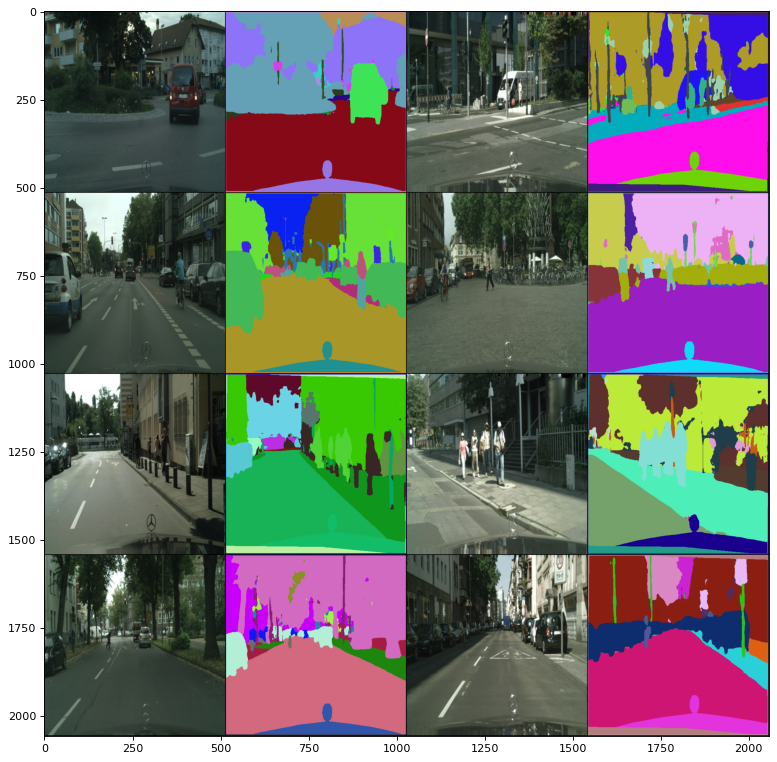

In [66]:
for batch in val_loader:
    imgs,labels=batch
    #plt.imshow(imgs.cpu().squeeze(0).numpy())
    preds=model(imgs.cuda())
    preds=preds.argmax(axis=1).cpu()
    gtvisimgs,predvisimgs=vis_Segmentation(imgs,preds)
    predvisimgs=predvisimgs.permute(0, 3, 1, 2)
    gtvisimgs=gtvisimgs.permute(0, 3, 1, 2)
    gridimgs=torch.stack([gtvisimgs/255,predvisimgs/255],dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(gridimgs, nrow=4)
    plt.figure(figsize=(12, 12), dpi=80)
    plt.imshow(grid.permute(1,2,0))
    break
    